<a href="https://colab.research.google.com/github/harishk30/DwarfResearch/blob/main/SAGAxCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install colossus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 2.8 MB/s eta 0:00:00


In [2]:
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo.concentration import concentration
from colossus.halo import profile_nfw
from colossus.halo import mass_adv
from colossus.cosmology import cosmology

In [3]:
import pandas as pd
import astropy.coordinates
from astropy.coordinates import SkyCoord
import numpy as np
from astropy import units as u
from astropy.cosmology import Planck15 as cosmo

In [4]:
from tqdm import tqdm

In [5]:
cosmology.setCosmology('planck15')

In [6]:
saga_hosts = '/content/drive/MyDrive/SummerProject/xSAGA-hosts_2021-09-28.parquet'
hosts = pd.read_parquet(saga_hosts, engine = 'auto')
satellites = pd.read_csv('/content/drive/MyDrive/SummerProject/xSAGA-lowz_2021-08-30.csv')

In [7]:
hosts = hosts.sort_values('mass_NSA', ascending = False)

In [8]:
#hosts = hosts[hosts['mass_GSE'] < 11]
satellite_coords = SkyCoord(satellites['ra'], satellites['dec'], unit = 'deg')
host_coords = SkyCoord(hosts['ra_NSA'], hosts['dec_NSA'], unit = 'deg')

In [ ]:
host_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(157.16630741, 14.33506305), (247.43729829, 40.811602  ),
     (181.66246902, 28.17453522), ..., (214.9766162 , 51.89505011),
     (173.53809004, -1.59561628), (208.34098059, 20.94890988)]>

In [9]:
UniverseMachine_params = {
    "alpha": 1.957,
    "beta": 0.474,
    "gamma": -1.065,
    "delta": 0.386,
    "epsilon": -1.435,
    "M0": 12.081,
}

def SHMR(M_halo, params):
    """Stellar Mass Halo Mass Relation from Behroozi+19. See Appendix J."""

    x = M_halo - params["M0"]

    return (
        params["M0"] + params["epsilon"]
        - np.log10(10**(-params["alpha"]*x) + 10**(-params["beta"]*x))
        + 10**params["gamma"]*np.exp(-0.5 * (x / params["delta"])**2)
    )

In [10]:
halo_masses = np.arange(11, 15, 0.001)
stellar_masses = SHMR(halo_masses, UniverseMachine_params)

In [11]:
def virial_mass(sm):
  return halo_masses[np.argmin((sm - stellar_masses)**2)]

In [12]:
def virial_radius(sm, z):
  vm = virial_mass(sm)
  return mass_so.M_to_R(10 ** vm, z, 'vir')

In [13]:
def r_to_deg(r, z):
  return (r * u.kpc / cosmo.kpc_proper_per_arcmin(z)).to(u.arcmin)

In [14]:
pairs = {}
assigned_satellites = set()
for id, host_coord in enumerate(tqdm(host_coords)):
  vr = virial_radius(hosts.iloc[id]['mass_NSA'], hosts.iloc[id]['z_NSA'])
  va = r_to_deg(vr, hosts.iloc[id]['z_NSA'])
  host_coord = SkyCoord(ra = [host_coords[id].ra], dec = [host_coords[id].dec])
  host_idx, satellite_idx, angsep, _ = host_coord.search_around_sky(satellite_coords, va)
  sep = (angsep * cosmo.kpc_proper_per_arcmin(hosts.iloc[id].z_NSA)).to(u.kpc)
  pairs[hosts.index[id]] = []
  for i, satellite_val in enumerate(host_idx):
    if(sep[i] > 36 * u.kpc):
      if(satellite_val not in assigned_satellites):
        pairs[hosts.index[id]].append(satellites.iloc[satellite_val]['objID'])
        assigned_satellites.add(satellite_val)

  0%|          | 21/12769 [00:06<1:10:20,  3.02it/s]


KeyboardInterrupt: 

In [15]:
def relative_velocity(z1, z2, c=299792.458):
    return c * abs(z1 - z2) / (1 + (z1 + z2) / 2)

In [16]:
pairedHosts = {}
assigned_hosts = set()
import math
for id, host_coord in enumerate(tqdm(host_coords)):
  if(hosts.index[id] not in assigned_hosts):
    vr = 1000 / math.sqrt(3)
    va = r_to_deg(vr, hosts.iloc[id]['z_NSA'])
    host_coord = SkyCoord(ra = [host_coords[id].ra], dec = [host_coords[id].dec])
    host_idx, paired_idx, angsep, _ = host_coord.search_around_sky(host_coords, va)
    sep = (angsep * cosmo.kpc_proper_per_arcmin(hosts.iloc[id].z_NSA)).to(u.kpc)
    pairedHosts[hosts.index[id]] = []
    for i, paired_val in enumerate(host_idx):
      relative_v = relative_velocity(hosts.iloc[paired_val]['z_NSA'], hosts.iloc[id]['z_NSA'])
      mass_diff = abs(hosts.iloc[paired_val]['mass_NSA'] - hosts.iloc[id]['mass_NSA'])
      if(relative_v < 500):
        if(sep[i] > (700 / math.sqrt(3)) * u.kpc):
          if(mass_diff < 0.5):
            if(paired_val not in assigned_hosts):
              pairedHosts[hosts.index[id]].append(hosts.index[paired_val])
              assigned_hosts.add(hosts.index[paired_val])
              assigned_hosts.add(hosts.index[id])

100%|█████████▉| 12765/12769 [07:53<00:00, 29.82it/s]<ipython-input-16-b105b1ff3bc2>:14: RuntimeWarning: invalid value encountered in scalar subtract
  mass_diff = abs(hosts.iloc[paired_val]['mass_NSA'] - hosts.iloc[id]['mass_NSA'])
100%|██████████| 12769/12769 [07:54<00:00, 26.94it/s]


In [17]:
print(pairedHosts)

{362161: [], 143497: [686856], 478320: [], 482763: [], 87215: [], 25819: [], 680542: [], 651237: [], 389045: [680694], 404058: [], 521639: [], 482746: [], 491484: [], 301345: [], 675185: [370510], 481305: [], 501770: [], 44879: [], 350702: [], 352469: [], 522694: [522638], 123564: [], 402395: [], 491469: [648329], 169512: [], 545471: [], 693198: [], 524729: [524756], 36385: [], 670711: [], 152850: [], 67532: [67519], 68049: [67519], 480091: [], 434161: [], 470513: [], 522643: [], 693021: [], 157378: [], 521559: [521534], 16094: [], 648294: [509920, 648295], 693210: [], 470777: [], 88203: [88226], 70335: [], 542191: [542224], 331546: [], 394663: [], 115521: [], 648009: [], 687797: [], 593683: [], 483194: [672400], 112644: [], 410935: [], 679776: [], 510541: [509920, 648295], 673907: [], 223234: [], 337771: [337811], 228996: [], 156126: [], 359263: [], 409487: [409501], 207306: [], 27338: [], 483200: [483381, 483144], 374473: [374502], 688869: [], 212405: [212463], 274783: [], 482474: [4

In [18]:
pairs = []
for i in range(len(hosts)):
  id = hosts.index[i]
  if id in pairedHosts:
    if(len(pairedHosts[id]) == 0):
      pairs.append(0)
    if(len(pairedHosts[id]) == 1):
      pairs.append(2)
    elif(len(pairedHosts[id]) >= 2):
      pairs.append(3)
  else:
    pairs.append(-1)

In [19]:
hosts['pairs'] = pairs

In [20]:
single = 0
pair = 0
multiple = 0
neg = 0
for i in range(len(hosts)):
  val = hosts.iloc[i]
  if(val['pairs'] == 0):
    single += 1
  elif(val['pairs'] == 2):
    pair += 1
  elif(val['pairs'] == 3):
    multiple += 1
  else:
    neg += 1


In [21]:
print(single, pair, multiple)

9107 1320 599


In [22]:
neg

1743

In [23]:
len(hosts)

12769

12769

In [24]:
for i in range(0, len(hosts)):
  if(hosts.iloc[i]['mass_NSA'] > 11):
    del pairedHosts[hosts.index[i]]

KeyError: 680694

In [26]:
sum = 0
tot = 0
for l in pairedHosts:
  if(len(pairedHosts[l]) != 0):
    sum += len(pairedHosts[l])
    tot += 1
print(sum/tot)

1.5850730688935282


In [27]:
for i in range(0, len(hosts)):
  if(hosts.iloc[i]['mass_NSA'] > 11):
    del pairs[hosts.index[i]]

IndexError: list assignment index out of range

In [ ]:
import csv

w = csv.writer(open("hostpairs.csv", "w"))

for key, val in pairs.items():

    w.writerow([key, val])

In [28]:
hosts = hosts[hosts['mass_NSA'] <= 11]

In [29]:
import csv
import ast

def read_csv_as_dict(file_path):
    with open(file_path, mode='r', newline='') as file:
        reader = csv.reader(file)
        data = {}
        for row in reader:
            key = row[0]
            # Convert the string representation of a list to an actual list
            value = ast.literal_eval(row[1])
            data[key] = value
    return data

In [30]:
pairs = read_csv_as_dict('/content/hostpairs (1).csv')

In [31]:
for i in range(0, len(hosts)):
  if(hosts.iloc[i]['z_NSA'] < 0.02):
    if str(hosts.index[i]) in pairs:
      del pairs[str(hosts.index[i])]

In [32]:
hosts = hosts[hosts['z_NSA'] >= 0.02]

In [33]:
hosts

,z_NSA,ra_NSA,dec_NSA,M_r_NSA,M_g_NSA,mass_NSA,SERSIC_N_NSA,SERSIC_BA_NSA,SERSIC_PHI_NSA,ELPETRO_BA_NSA,...,MJD,FIBERID,mass_GSE,mass_err_GSE,n_sats_in_300kpc,n_sats_in_150kpc,n_bright_sats_in_300kpc,N_unrelated_lowz,n_corr_sats_in_300kpc,pairs
NSAID,,,,,,,,,,,,,,,,,,,,,
350702,0.025517,217.606577,11.927973,-22.025835,-21.269285,10.984602,5.257183,0.857721,120.447998,0.910484,...,53504,317,11.326582,0.086736,3,2,3,0.023889,4.785405,0
352469,0.029077,224.150682,9.369723,-22.206125,-21.470406,10.968457,6.000000,0.665823,84.467041,0.697892,...,54212,193,11.212667,0.087128,8,3,8,0.029606,13.155597,0
522694,0.023125,176.550767,20.391653,-21.987951,-21.289984,10.962545,6.000000,0.734939,12.358368,0.772986,...,54180,492,11.173956,0.081876,5,2,5,0.035396,8.067079,2
123564,0.025188,344.508086,13.134494,-21.964119,-21.223104,10.961491,6.000000,0.679418,45.890747,0.731137,...,52261,12,11.232985,0.080872,5,2,5,0.023366,8.114398,0
402395,0.027054,123.936865,58.321011,-21.972540,-21.175783,10.959362,3.853148,0.785757,100.288239,0.841223,...,54437,391,11.272670,0.085734,1,0,1,0.026347,1.470034,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223240,0.028972,246.393312,40.787191,-17.915770,-15.755199,7.787176,0.500000,1.000000,117.718842,0.880065,...,52759,457,9.649350,0.094504,0,0,0,0.029435,-0.178604,0
325710,0.025637,184.642937,12.855764,-18.330580,-17.478563,5.079427,1.436873,0.306668,147.662933,0.469843,...,53120,356,9.752282,0.092904,0,0,0,0.024082,-0.213055,0
223226,0.029857,246.441544,39.609182,-8.395647,-9.839364,3.560767,0.709980,0.205326,156.155151,0.183755,...,52759,435,10.985835,0.086237,3,0,3,0.030867,4.828380,0


In [34]:
n_sat = []

In [35]:
for i in range(0, len(hosts)):
  if str(hosts.index[i]) in pairs:
    n_sat.append(len(pairs[str(hosts.index[i])]))
  else:
    n_sat.append(0)

In [36]:
hosts['n_sat'] = n_sat

In [37]:
hosts['n_sat']

NSAID
350702     5
352469    18
522694    10
123564     7
402395     2
          ..
223240     0
325710     0
223226     0
208673     0
17347      0
Name: n_sat, Length: 10408, dtype: int64

In [38]:
bin1 = []
bin2 = []
bin3 = []
bin4 = []

In [39]:
for i in range(0, len(hosts)):
  val = hosts.iloc[i]
  if(val['mass_NSA'] < 9.5 and val['mass_NSA'] >= 9):
    bin1.append(val['n_sat'])
  elif(val['mass_NSA'] < 10 and val['mass_NSA'] >= 9.5):
    bin2.append(val['n_sat'])
  elif(val['mass_NSA'] < 10.5 and val['mass_NSA'] >= 10):
    bin3.append(val['n_sat'])
  else:
    bin4.append(val['n_sat'])

In [42]:
del sum

Text(0.5, 1.0, 'Average Satellites vs Mass')

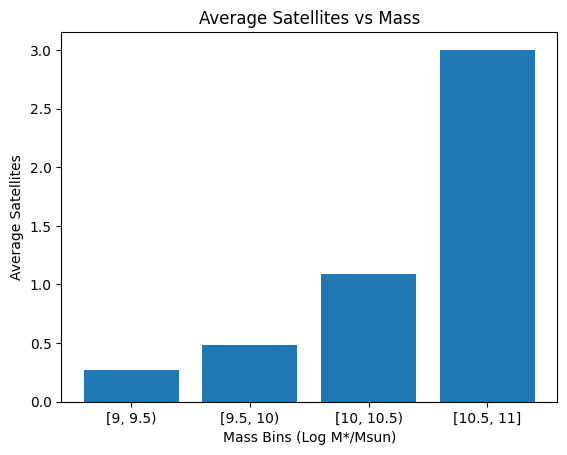

In [43]:
import matplotlib.pyplot as plt
groups = ['[9, 9.5)', '[9.5, 10)', '[10, 10.5)', '[10.5, 11]']
values = [sum(bin1)/len(bin1), sum(bin2)/len(bin2), sum(bin3)/len(bin3), sum(bin4)/len(bin4)]
plt.bar(groups, values)
plt.xlabel('Mass Bins (Log M*/Msun)')
plt.ylabel('Average Satellites')
plt.title('Average Satellites vs Mass')

Text(0, 0.5, 'Frequency')

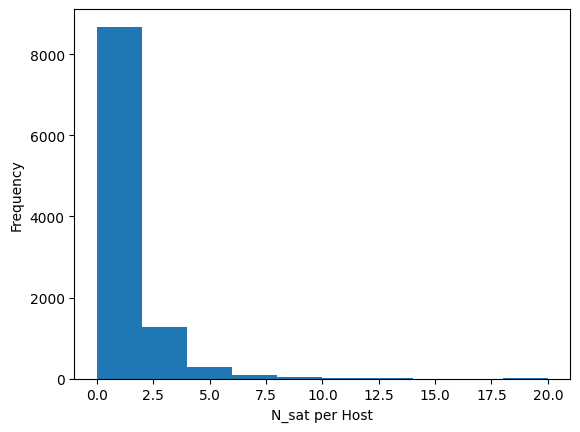

In [41]:
plt.hist(n_sat, bins = 10, range = (0, 20))
plt.xlabel('N_sat per Host')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

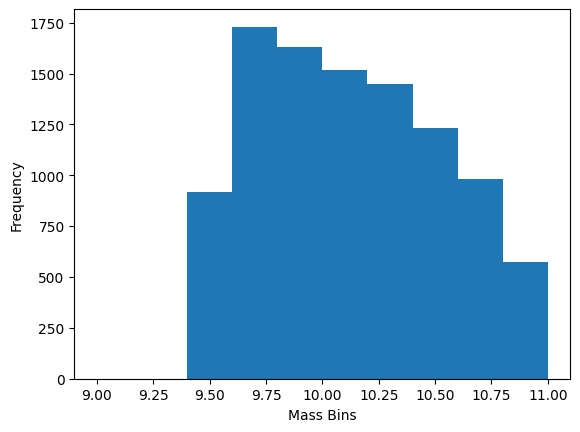

In [44]:
plt.hist(hosts['mass_GSE'], bins = 10, range = (9, 11))
plt.xlabel('Mass Bins')
plt.ylabel('Frequency')

In [45]:
hosts

,z_NSA,ra_NSA,dec_NSA,M_r_NSA,M_g_NSA,mass_NSA,SERSIC_N_NSA,SERSIC_BA_NSA,SERSIC_PHI_NSA,ELPETRO_BA_NSA,...,FIBERID,mass_GSE,mass_err_GSE,n_sats_in_300kpc,n_sats_in_150kpc,n_bright_sats_in_300kpc,N_unrelated_lowz,n_corr_sats_in_300kpc,pairs,n_sat
NSAID,,,,,,,,,,,,,,,,,,,,,
350702,0.025517,217.606577,11.927973,-22.025835,-21.269285,10.984602,5.257183,0.857721,120.447998,0.910484,...,317,11.326582,0.086736,3,2,3,0.023889,4.785405,0,5
352469,0.029077,224.150682,9.369723,-22.206125,-21.470406,10.968457,6.000000,0.665823,84.467041,0.697892,...,193,11.212667,0.087128,8,3,8,0.029606,13.155597,0,18
522694,0.023125,176.550767,20.391653,-21.987951,-21.289984,10.962545,6.000000,0.734939,12.358368,0.772986,...,492,11.173956,0.081876,5,2,5,0.035396,8.067079,2,10
123564,0.025188,344.508086,13.134494,-21.964119,-21.223104,10.961491,6.000000,0.679418,45.890747,0.731137,...,12,11.232985,0.080872,5,2,5,0.023366,8.114398,0,7
402395,0.027054,123.936865,58.321011,-21.972540,-21.175783,10.959362,3.853148,0.785757,100.288239,0.841223,...,391,11.272670,0.085734,1,0,1,0.026347,1.470034,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223240,0.028972,246.393312,40.787191,-17.915770,-15.755199,7.787176,0.500000,1.000000,117.718842,0.880065,...,457,9.649350,0.094504,0,0,0,0.029435,-0.178604,0,0
325710,0.025637,184.642937,12.855764,-18.330580,-17.478563,5.079427,1.436873,0.306668,147.662933,0.469843,...,356,9.752282,0.092904,0,0,0,0.024082,-0.213055,0,0
223226,0.029857,246.441544,39.609182,-8.395647,-9.839364,3.560767,0.709980,0.205326,156.155151,0.183755,...,435,10.985835,0.086237,3,0,3,0.030867,4.828380,0,0


In [46]:
def absolute_to_apparent(M, z):
  D_L = cosmo.luminosity_distance(0.6).value * 1e6
  mu = 5 * np.log10(D_L) - 5
  return M + mu

In [47]:
def g_r(Mr, Mg, z):
  mr = absolute_to_apparent(Mr, z)
  mg = absolute_to_apparent(Mg, z)
  return mg - mr

In [48]:
g_r_color = []
for i in range(0, len(hosts)):
  val = hosts.iloc[i]
  g_r_color.append(g_r(val['M_r_NSA'], val['M_g_NSA'], val['z_NSA']))

<ipython-input-47-2081d618248b>:4: RuntimeWarning: invalid value encountered in scalar subtract
  return mg - mr


In [49]:
hosts['g-r'] = g_r_color

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   3.,
          4.,   4.,   9.,  16.,  27.,  48.,  69.,  97., 163., 215., 247.,
        294., 354., 345., 377., 361., 381., 384., 365., 416., 471., 530.,
        696., 820., 920., 913., 787., 536., 272., 121.,  70.,  32.,  12.,
         13.,   2.,   5.,   2.,   2.,   0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

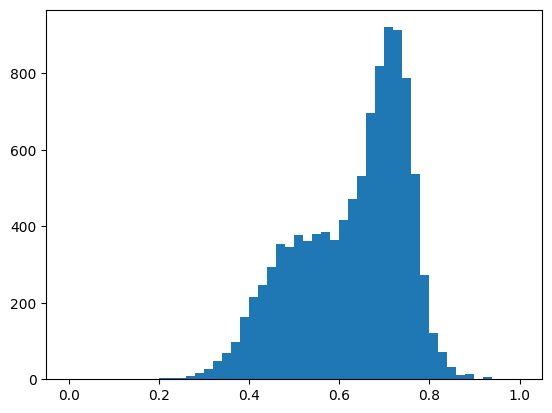

In [50]:
plt.hist(list(hosts['g-r']), range = (0, 1), bins = 50)

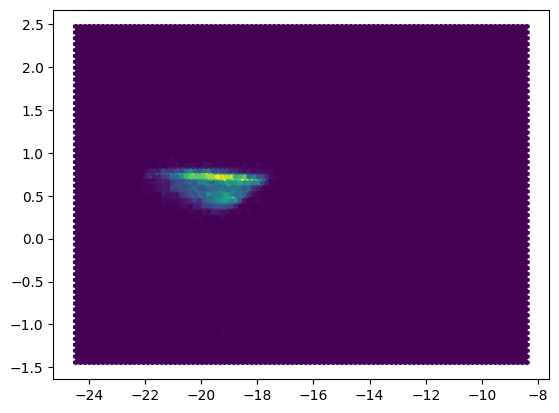

In [51]:
plt.hexbin(list(hosts['M_r_NSA']), list(hosts['g-r']))

In [52]:
def bootstrap_resample(data, num_resamples=10000):
    n = len(data)
    resamples = np.random.choice(data, (num_resamples, n), replace=True)
    return resamples

def calculate_bootstrap_statistics(data, num_resamples=10000):
    resamples = bootstrap_resample(data, num_resamples)
    resampled_means = np.mean(resamples, axis=1)
    mean = np.mean(resampled_means)
    std_error = np.std(resampled_means)
    return mean, std_error

In [53]:
filtered_df = hosts

In [54]:
g_r_colors = np.array(list(filtered_df['g-r']))
satellites = np.array(list(filtered_df['n_sat']))
masses = np.array(list(filtered_df['mass_NSA']))
indices = np.array([i for i in range(0, len(filtered_df))])
mask = (g_r_colors >= 0) & (g_r_colors <= 1)
filtered_satellites = satellites[mask]
filtered_g_r_colors = g_r_colors[mask]
filtered_masses = masses[mask]
filtered_indices = indices[mask]

In [55]:
bins = np.linspace(0, 1, 6)
digitized = np.digitize(filtered_g_r_colors, bins)
average_satellites = [filtered_satellites[digitized == i].mean() if len(filtered_satellites[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [56]:
quartiles = np.percentile(filtered_masses, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile']
colors = ['blue', 'green', 'red', 'orange']

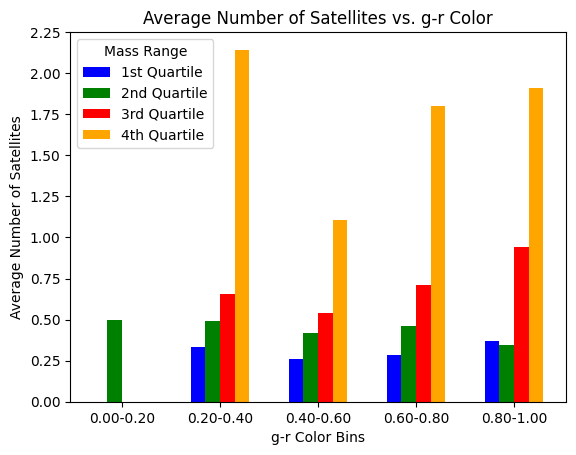

In [57]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses >= x) & (filtered_masses < mass_range[1])
    filtered_satellites_mass = filtered_satellites[mass_mask]
    filtered_g_r_colors_mass = filtered_g_r_colors[mass_mask]

    digitized_mass = np.digitize(filtered_g_r_colors_mass, bins)
    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('g-r Color Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. g-r Color')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

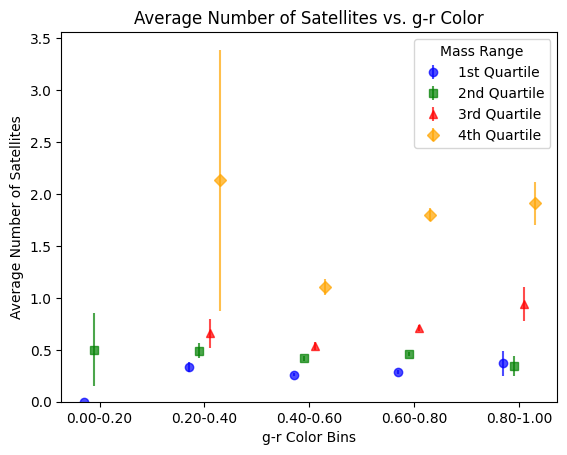

In [58]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses >= x) & (filtered_masses < mass_range[1])
    filtered_satellites_mass = filtered_satellites[mass_mask]
    filtered_g_r_colors_mass = filtered_g_r_colors[mass_mask]

    digitized_mass = np.digitize(filtered_g_r_colors_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 0:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('g-r Color Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. g-r Color')
ax.legend(title='Mass Range')
ax.set_ylim(bottom = 0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

In [59]:
from astropy.io import fits
gse = fits.getdata('/content/drive/MyDrive/galSpecExtra-dr8.fits')
def byteorder(row):
  return row.byteswap().newbyteorder()
gse = pd.DataFrame(
        {
            "PLATE": byteorder(gse.PLATEID),
            "MJD": byteorder(gse.MJD),
            "FIBERID": byteorder(gse.FIBERID),
            "Metalicity": byteorder(gse.OH_P50),
            "SFR": byteorder(gse.SFR_TOT_P50),
            "BPT_CLASS": byteorder(gse.BPTCLASS)
        }
)

In [60]:
gse

,PLATE,MJD,FIBERID,Metalicity,SFR,BPT_CLASS
0,266,51602,1,-9999.0,-0.520650,3
1,266,51602,2,-9999.0,-0.349722,-1
2,266,51602,3,-9999.0,-9999.000000,-1
3,266,51602,4,-9999.0,-1.124918,-1
4,266,51602,5,-9999.0,-9999.000000,-1
...,...,...,...,...,...,...
1843195,-1,-1,-1,0.0,0.000000,0
1843196,-1,-1,-1,0.0,0.000000,0
1843197,-1,-1,-1,0.0,0.000000,0
1843198,-1,-1,-1,0.0,0.000000,0


In [61]:
join_columns = ["PLATE", "MJD", "FIBERID"]
hosts_comb = hosts.join(gse.set_index(join_columns), on=join_columns, how="left")

In [62]:
hosts_comb['Metalicity']

NSAID
350702   -9999.000000
352469   -9999.000000
522694   -9999.000000
123564   -9999.000000
402395   -9999.000000
             ...     
223240   -9999.000000
325710   -9999.000000
223226   -9999.000000
208673       9.029759
17347    -9999.000000
Name: Metalicity, Length: 10408, dtype: float32

(array([  0.,   0.,   0.,   1.,   1.,   0.,   3.,  12.,   5.,  34.,  44.,
        119., 142., 291., 352., 507., 718., 527., 584., 235.,  47.,  20.,
          1.,   2.,   0.]),
 array([8.  , 8.06, 8.12, 8.18, 8.24, 8.3 , 8.36, 8.42, 8.48, 8.54, 8.6 ,
        8.66, 8.72, 8.78, 8.84, 8.9 , 8.96, 9.02, 9.08, 9.14, 9.2 , 9.26,
        9.32, 9.38, 9.44, 9.5 ]),
 <BarContainer object of 25 artists>)

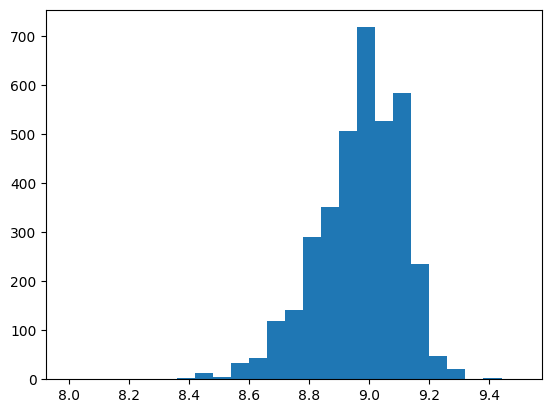

In [63]:
plt.hist(list(hosts_comb['Metalicity']), bins = 25, range = (8.0, 9.5))

In [64]:
metallicity = np.array(list(hosts_comb['Metalicity']))
mask = (metallicity >= 8.5) & (metallicity <= 9.5)
filtered_satellites_new = satellites[mask]
filtered_metallicity = metallicity[mask]
filtered_masses_new = masses[mask]

In [65]:
bins = np.linspace(8.5, 9.5, 6)
digitized = np.digitize(filtered_metallicity, bins)
average_satellites = [filtered_satellites_new[digitized == i].mean() if len(filtered_satellites_new[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [66]:
quartiles = np.percentile(filtered_masses_new, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile']
colors = ['blue', 'green', 'red', 'orange']

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


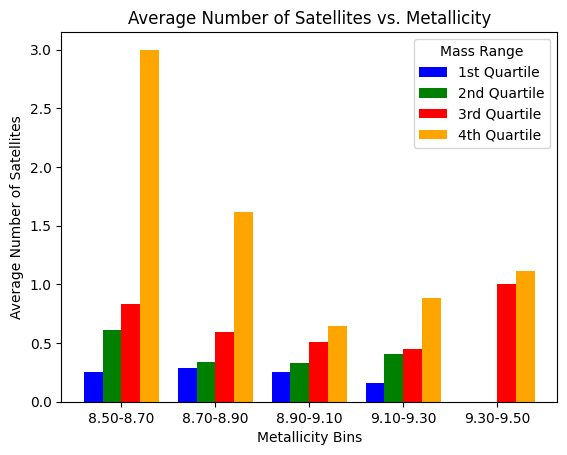

In [67]:
fig, ax = plt.subplots()

bar_width = 0.04
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_new >= x) & (filtered_masses_new < mass_range[1])
    filtered_satellites_mass = filtered_satellites_new[mass_mask]
    filtered_metallicity_mass = filtered_metallicity[mass_mask]

    digitized_mass = np.digitize(filtered_metallicity_mass, bins)

    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('Metallicity Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. Metallicity')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

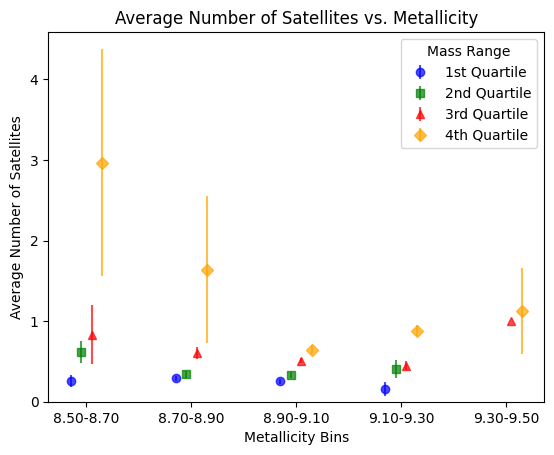

In [68]:
fig, ax = plt.subplots()

bar_width = 0.04
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_new >= x) & (filtered_masses_new < mass_range[1])
    filtered_satellites_mass = filtered_satellites_new[mass_mask]
    filtered_metallicity_mass = filtered_metallicity[mass_mask]

    digitized_mass = np.digitize(filtered_metallicity_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 0:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('Metallicity Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. Metallicity')
ax.legend(title='Mass Range')
ax.set_ylim(ymin=0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

(array([   9.,  133., 1138., 2188., 1247., 1595., 2590., 1178.,  199.,
          24.]),
 array([-3.  , -2.57, -2.14, -1.71, -1.28, -0.85, -0.42,  0.01,  0.44,
         0.87,  1.3 ]),
 <BarContainer object of 10 artists>)

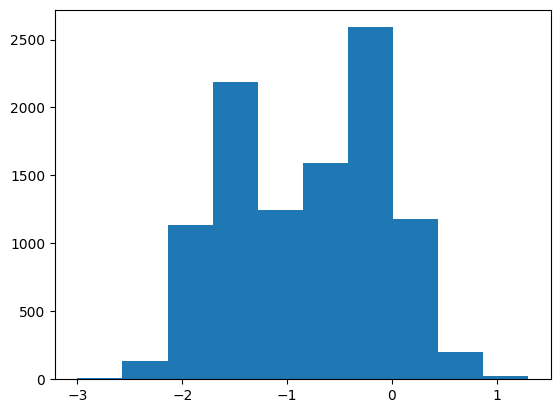

In [69]:
plt.hist(list(hosts_comb['SFR']), bins = 10, range = (-3, 1.3))

In [70]:
sfr = np.array(list(hosts_comb['SFR']))
mask = (sfr >= -3) & (sfr <= 1)
filtered_satellites_sfr = satellites[mask]
filtered_sfr = sfr[mask]
filtered_masses_sfr = masses[mask]

In [71]:
bins = np.linspace(-3, 1, 6)
digitized = np.digitize(filtered_sfr, bins)
average_satellites = [filtered_satellites_sfr[digitized == i].mean() if len(filtered_satellites_sfr[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [72]:
quartiles = np.percentile(filtered_masses_sfr, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile']
colors = ['blue', 'green', 'red', 'orange']

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


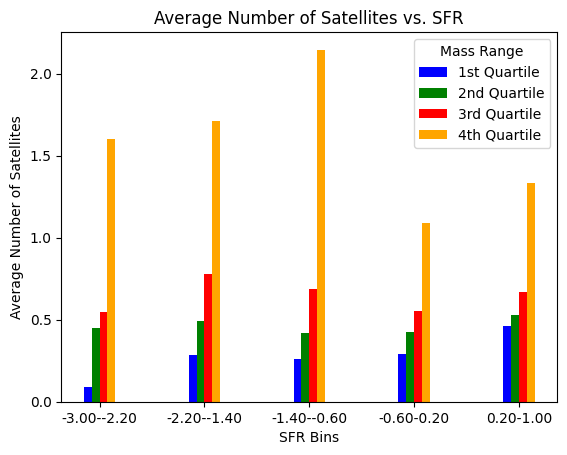

In [73]:
fig, ax = plt.subplots()

bar_width = 0.06
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_sfr >= x) & (filtered_masses_sfr < mass_range[1])
    filtered_satellites_mass = filtered_satellites_sfr[mass_mask]
    filtered_sfr_mass = filtered_sfr[mass_mask]

    digitized_mass = np.digitize(filtered_sfr_mass, bins)
    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('SFR Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. SFR')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

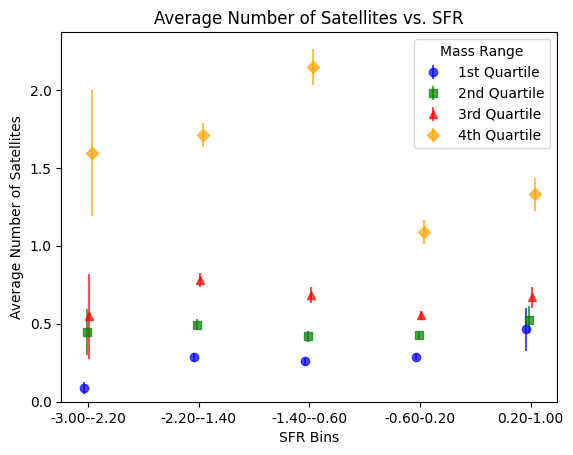

In [74]:
fig, ax = plt.subplots()

bar_width = 0.04
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_sfr >= x) & (filtered_masses_sfr < mass_range[1])
    filtered_satellites_mass = filtered_satellites_sfr[mass_mask]
    filtered_sfr_mass = filtered_sfr[mass_mask]

    digitized_mass = np.digitize(filtered_sfr_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 0:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('SFR Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. SFR')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)
ax.set_ylim(ymin=0)

plt.show()

In [75]:
def corrected_sats(sats, z, sm):
    # Calculate square degrees per square kiloparsec
    sq_deg_per_sq_kpc = (cosmo.arcsec_per_kpc_proper(z).to(u.deg / u.kpc).value) ** 2

    # Calculate the virial radius and subtract the 36 kpc radius
    virial_rad = virial_radius(sm, z) * u.kpc
    radius_diff = ((virial_rad)**2 - (36 * u.kpc)**2).to(u.kpc**2).value

    # Calculate the surface area in square degrees
    surface_area = np.pi * radius_diff * sq_deg_per_sq_kpc

    vol = volume(z)

    # Compute the correction factor
    corr = (sats / completeness(z)) - 3.04 * surface_area - vol

    return corr

In [76]:
def fp_vol(sats, z, sm):
    # Calculate square degrees per square kiloparsec
    sq_deg_per_sq_kpc = (cosmo.arcsec_per_kpc_proper(z).to(u.deg / u.kpc).value) ** 2

    # Calculate the virial radius and subtract the 36 kpc radius
    virial_rad = virial_radius(sm, z) * u.kpc
    radius_diff = ((virial_rad)**2 - (36 * u.kpc)**2).to(u.kpc**2).value

    # Calculate the surface area in square degrees
    surface_area = np.pi * radius_diff * sq_deg_per_sq_kpc

    vol = volume(z)

    # Compute the correction factor
    return [3.04 * surface_area, vol]

In [77]:
# Pencil-ish volume
def volume(z, delta_z = 0.005):
    z_upper = z + delta_z
    z_lower = z - delta_z
    z_upper = min(z_upper, 0.03)
    z_lower = max(z_lower, 0)

    total_volume = (
        (cosmo.comoving_volume(0.03) - cosmo.comoving_volume(z_upper)) / 1.03**3 +
        (cosmo.comoving_volume(z_lower)) / (1 + z_lower)**3
    )

    volume = (
        ((cosmo.kpc_proper_per_arcmin(z) / (300 * u.kpc))**-2)
        .to(u.steradian)
        .value
        / (4 * np.pi)
        * total_volume
    )

    return (0.0142 * u.Mpc**-3) * volume

In [78]:
n_fp = []
n_non_satellite = []

In [97]:
n_sats_corr = []
for i in range(0, len(hosts)):
  val = hosts.iloc[i]
  n_sats_corr.append(corrected_sats(val['n_sat'], val['z_NSA'], val['mass_NSA']))
  vals = fp_vol(val['n_sat'], val['z_NSA'], val['mass_NSA'])
  n_fp.append(vals[0])
  n_non_satellite.append(vals[1])

In [98]:
hosts['n_fp'] = n_fp
hosts['n_non_satellite'] = n_non_satellite

In [99]:
hosts['n_sats_corr'] = n_sats_corr

In [100]:
g_r_colors = np.array(list(hosts['g-r']))
satellites = np.array(list(hosts['n_sats_corr']))
masses = np.array(list(hosts['mass_NSA']))
redshifts = np.array(list(hosts['z_NSA']))
indices = np.array([i for i in range(0, len(hosts))])
mask = (g_r_colors >= 0) & (g_r_colors <= 1)
filtered_satellites = satellites[mask]
filtered_g_r_colors = g_r_colors[mask]
filtered_masses = masses[mask]
filtered_indices = indices[mask]
filtered_redshifts = redshifts[mask]

In [101]:
bins = np.linspace(0, 1, 6)
digitized = np.digitize(filtered_g_r_colors, bins)
average_satellites = [filtered_satellites[digitized == i].mean() if len(filtered_satellites[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [102]:
quartiles = np.percentile(filtered_masses, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = [str(round(np.median(filtered_masses[(filtered_masses >= mass_range[0]) & (filtered_masses < mass_range[1])]), 2)) for mass_range in mass_ranges]
colors = ['blue', 'green', 'red', 'orange']

In [103]:
import numpy as np

# Define mass bins
mass_ranges = [(9.5, 9.75), (9.75, 10), (10, 10.5), (10.5, 11)]

# Create labels for the mass bins
mass_labels = []
for mass_range in mass_ranges:
    x = mass_range[0]
    y = mass_range[1]
    median_mass = np.median(filtered_masses_new[(filtered_masses_new >= x) & (filtered_masses_new < y)])
    mass_labels.append(str(round(median_mass, 2)))

# Define colors for each bin
colors = ['blue', 'green', 'red', 'orange']

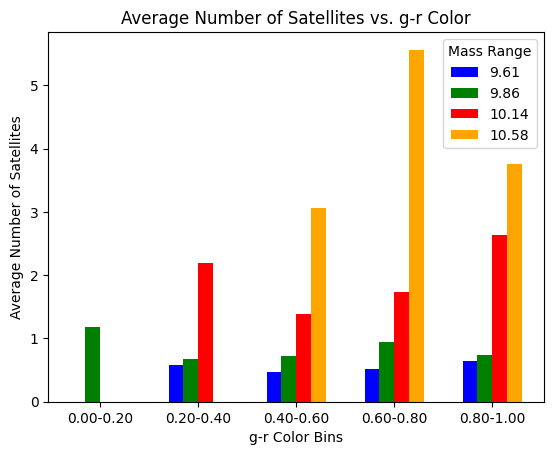

In [104]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses >= x) & (filtered_masses < mass_range[1])
    filtered_satellites_mass = filtered_satellites[mass_mask]
    filtered_g_r_colors_mass = filtered_g_r_colors[mass_mask]

    digitized_mass = np.digitize(filtered_g_r_colors_mass, bins)
    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('g-r Color Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. g-r Color')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)
ax.set_ylim(bottom = 0)

plt.show()

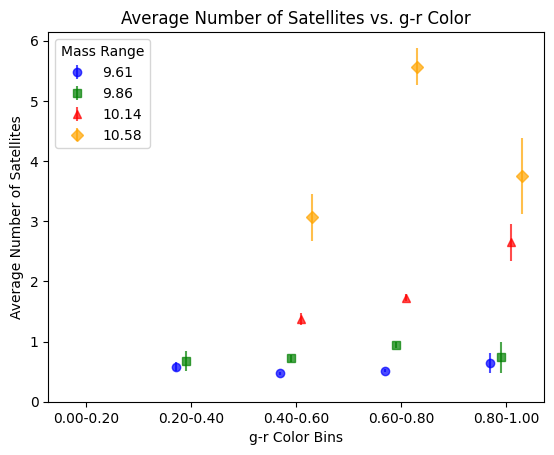

In [105]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses >= x) & (filtered_masses < mass_range[1])
    filtered_satellites_mass = filtered_satellites[mass_mask]
    filtered_g_r_colors_mass = filtered_g_r_colors[mass_mask]

    digitized_mass = np.digitize(filtered_g_r_colors_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 30:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('g-r Color Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. g-r Color')
ax.legend(title='Mass Range')
ax.set_ylim(bottom = 0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

In [106]:
quartiles = np.percentile(filtered_redshifts, [0, 25, 50, 75, 100])
redshift_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
redshift_labels = [str(round(np.median(filtered_redshifts[(filtered_redshifts >= redshift_range[0]) & (filtered_redshifts < redshift_range[1])]), 4)) for redshift_range in redshift_ranges]
colors = ['blue', 'green', 'red', 'orange']

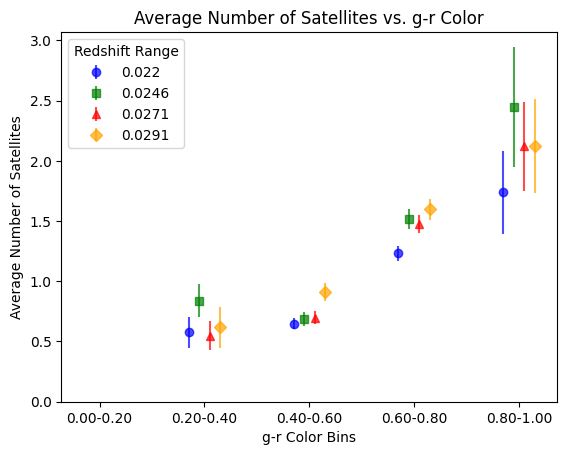

In [107]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (redshift_range, color, marker, label) in enumerate(zip(redshift_ranges, colors, markers, redshift_labels)):
    x = redshift_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    redshift_mask = (filtered_redshifts >= x) & (filtered_redshifts < redshift_range[1])
    filtered_satellites_redshift = filtered_satellites[redshift_mask]
    filtered_g_r_colors_redshift = filtered_g_r_colors[redshift_mask]

    digitized_mass = np.digitize(filtered_g_r_colors_redshift, bins)

    avg_satellites_redshift = []
    std_satellites_redshift = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_redshift[digitized_mass == i]
        if len(bin_values) > 30:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_redshift.append(mean)
            std_satellites_redshift.append(std_error)
        else:
            avg_satellites_redshift.append(np.nan)
            std_satellites_redshift.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_redshift, yerr=std_satellites_redshift, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('g-r Color Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. g-r Color')
ax.legend(title='Redshift Range')
ax.set_ylim(bottom = 0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

In [108]:
metallicity = np.array(list(hosts_comb['Metalicity']))
mask = (metallicity >= 8.5) & (metallicity <= 9.5)
filtered_satellites_new = satellites[mask]
filtered_metallicity = metallicity[mask]
filtered_masses_new = masses[mask]
filtered_redshifts = redshifts[mask]

In [109]:
bins = np.linspace(8.5, 9.5, 6)
digitized = np.digitize(filtered_metallicity, bins)
average_satellites = [filtered_satellites_new[digitized == i].mean() if len(filtered_satellites_new[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [110]:
quartiles = np.percentile(filtered_masses_new, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = []
i = 0
for mass_range in mass_ranges:
  x = mass_range[0]
  if(i == 0):
    x = -np.inf
  i += 1
  mass_labels.append(str(round(np.median(filtered_masses_new[(filtered_masses_new >= x) & (filtered_masses_new <  mass_range[1])]), 2)))
colors = ['blue', 'green', 'red', 'orange']

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


In [111]:
import numpy as np

# Define mass bins
mass_ranges = [(9.5, 9.75), (9.75, 10), (10, 10.5), (10.5, 11)]

# Create labels for the mass bins
mass_labels = []
for mass_range in mass_ranges:
    x = mass_range[0]
    y = mass_range[1]
    median_mass = np.median(filtered_masses_new[(filtered_masses_new >= x) & (filtered_masses_new < y)])
    mass_labels.append(str(round(median_mass, 2)))

# Define colors for each bin
colors = ['blue', 'green', 'red', 'orange']

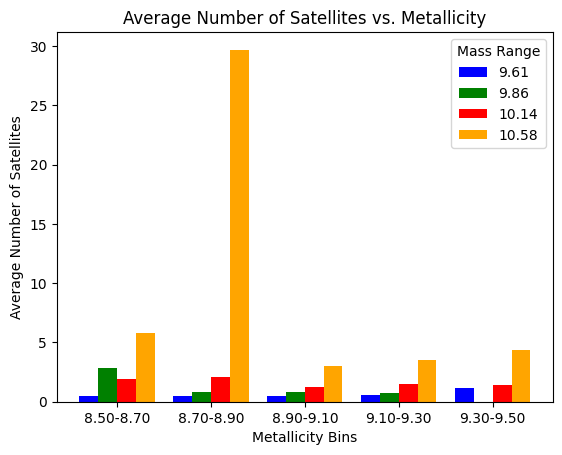

In [112]:
fig, ax = plt.subplots()

bar_width = 0.04
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_new >= x) & (filtered_masses_new < mass_range[1])
    filtered_satellites_mass = filtered_satellites_new[mass_mask]
    filtered_metallicity_mass = filtered_metallicity[mass_mask]

    digitized_mass = np.digitize(filtered_metallicity_mass, bins)

    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('Metallicity Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. Metallicity')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

nan


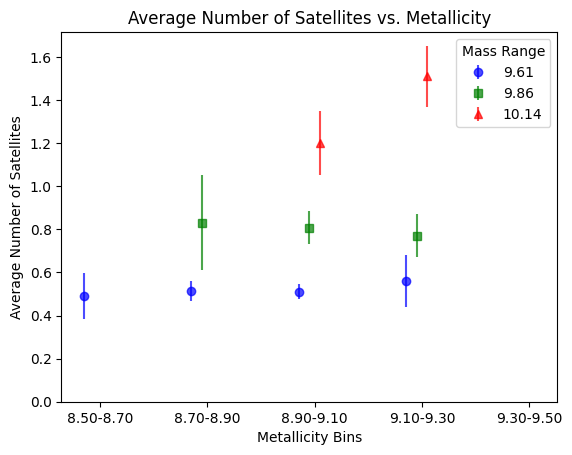

In [113]:
fig, ax = plt.subplots()

bar_width = 0.04
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_new >= x) & (filtered_masses_new < mass_range[1])
    filtered_satellites_mass = filtered_satellites_new[mass_mask]
    filtered_metallicity_mass = filtered_metallicity[mass_mask]

    digitized_mass = np.digitize(filtered_metallicity_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 30:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02
    try:
      ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)
    except:
      print("nan")

ax.set_xlabel('Metallicity Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. Metallicity')
ax.legend(title='Mass Range')
ax.set_ylim(ymin=0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

In [114]:
m = list(hosts_comb[hosts_comb['Metalicity'] > 0]['BPT_CLASS'] != 1)

In [115]:
masses = []
metallicities = []
corrected_sats = []
for i in range(len(hosts)):
  val = hosts.iloc[i]
  if(val['mass_NSA'] >= 9.5):
    if(hosts_comb.iloc[i]['Metalicity'] >= 8.5 and hosts_comb.iloc[i]['Metalicity'] <= 9.5):
      masses.append(val['mass_NSA'])
      metallicities.append(hosts_comb.iloc[i]['Metalicity'])
      corrected_sats.append(hosts_comb.iloc[i]['BPT_CLASS'])


In [116]:
hosts.columns

Index(['z_NSA', 'ra_NSA', 'dec_NSA', 'M_r_NSA', 'M_g_NSA', 'mass_NSA',
       'SERSIC_N_NSA', 'SERSIC_BA_NSA', 'SERSIC_PHI_NSA', 'ELPETRO_BA_NSA',
       'PLATE', 'MJD', 'FIBERID', 'mass_GSE', 'mass_err_GSE',
       'n_sats_in_300kpc', 'n_sats_in_150kpc', 'n_bright_sats_in_300kpc',
       'N_unrelated_lowz', 'n_corr_sats_in_300kpc', 'pairs', 'n_sat', 'g-r',
       'n_fp', 'n_non_satellite', 'n_sats_corr'],
      dtype='object')

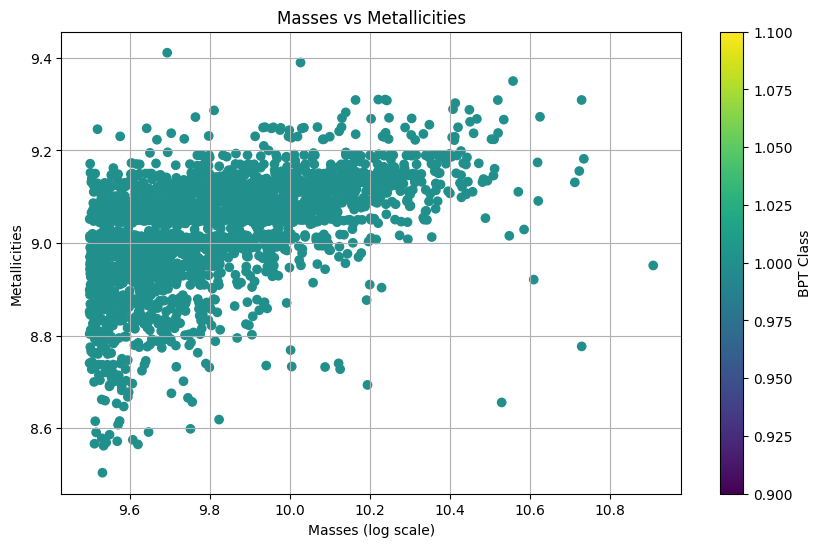

In [117]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(masses, metallicities, c=corrected_sats, cmap='viridis')
plt.colorbar(scatter, label='BPT Class')
plt.xlabel('Masses (log scale)')
plt.ylabel('Metallicities')
plt.title('Masses vs Metallicities')
plt.grid(True)
plt.show()

In [118]:

quartiles = np.percentile(filtered_redshifts, [0, 25, 50, 75, 100])
redshift_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
redshift_labels = [str(round(np.median(filtered_redshifts[(filtered_redshifts >= redshift_range[0]) & (filtered_redshifts <redshift_range[1])]), 4)) for redshift_range in redshift_ranges]
colors = ['blue', 'green', 'red', 'orange']

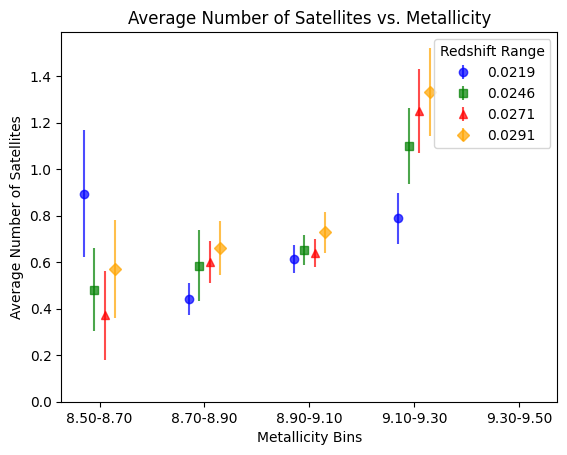

In [119]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (redshift_range, color, marker, label) in enumerate(zip(redshift_ranges, colors, markers, redshift_labels)):
    x = redshift_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    redshift_mask = (filtered_redshifts >= x) & (filtered_redshifts < redshift_range[1])
    filtered_satellites_redshift = filtered_satellites_new[redshift_mask]
    filtered_metallicity_redshift = filtered_metallicity[redshift_mask]

    digitized_mass = np.digitize(filtered_metallicity_redshift, bins)

    avg_satellites_redshift = []
    std_satellites_redshift = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_redshift[digitized_mass == i]
        if len(bin_values) > 30:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_redshift.append(mean)
            std_satellites_redshift.append(std_error)
        else:
            avg_satellites_redshift.append(np.nan)
            std_satellites_redshift.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_redshift, yerr=std_satellites_redshift, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('Metallicity Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. Metallicity')
ax.legend(title='Redshift Range')
ax.set_ylim(bottom = 0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

In [120]:
sfr = np.array(list(hosts_comb['SFR']))
mask = (sfr >= -3) & (sfr <= 1)
filtered_satellites_sfr = satellites[mask]
filtered_sfr = sfr[mask]
filtered_masses_sfr = masses[mask]
filtered_redshifts = redshifts[mask]

TypeError: only integer scalar arrays can be converted to a scalar index

In [121]:
bins = np.linspace(-3, 1, 6)
digitized = np.digitize(filtered_sfr, bins)
average_satellites = [filtered_satellites_sfr[digitized == i].mean() if len(filtered_satellites_sfr[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [122]:
quartiles = np.percentile(filtered_masses_sfr, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = []
i = 0
for mass_range in mass_ranges:
  x = mass_range[0]
  if(i == 0):
    x = -np.inf
  i += 1
  mass_labels.append(str(round(np.median(filtered_masses_sfr[(filtered_masses_sfr >= x) & (filtered_masses_sfr <  mass_range[1])]), 2)))
colors = ['blue', 'green', 'red', 'orange']

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [123]:
import numpy as np

# Define mass bins
mass_ranges = [(9.5, 9.75), (9.75, 10), (10, 10.5), (10.5, 11)]

# Create labels for the mass bins
mass_labels = []
for mass_range in mass_ranges:
    x = mass_range[0]
    y = mass_range[1]
    median_mass = np.median(filtered_masses_new[(filtered_masses_new >= x) & (filtered_masses_new < y)])
    mass_labels.append(str(round(median_mass, 2)))

# Define colors for each bin
colors = ['blue', 'green', 'red', 'orange']

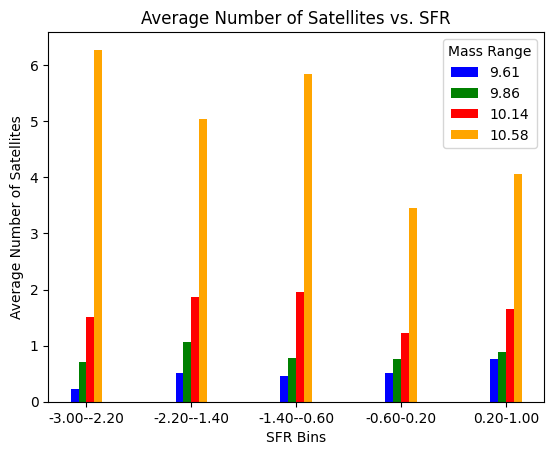

In [124]:
fig, ax = plt.subplots()

bar_width = 0.06
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_sfr >= x) & (filtered_masses_sfr < mass_range[1])
    filtered_satellites_mass = filtered_satellites_sfr[mass_mask]
    filtered_sfr_mass = filtered_sfr[mass_mask]

    digitized_mass = np.digitize(filtered_sfr_mass, bins)
    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('SFR Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. SFR')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

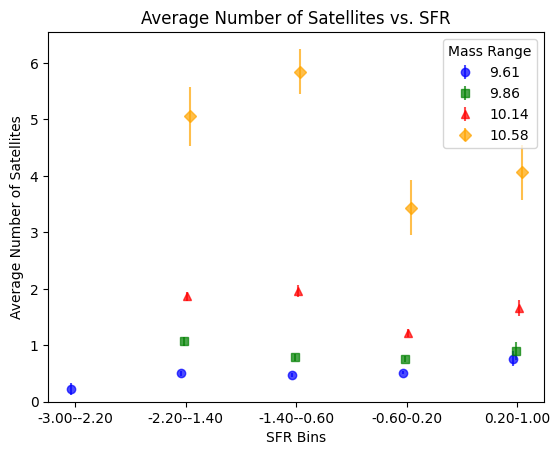

In [125]:
fig, ax = plt.subplots()

bar_width = 0.04
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_sfr >= x) & (filtered_masses_sfr < mass_range[1])
    filtered_satellites_mass = filtered_satellites_sfr[mass_mask]
    filtered_sfr_mass = filtered_sfr[mass_mask]

    digitized_mass = np.digitize(filtered_sfr_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 30:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('SFR Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. SFR')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)
ax.set_ylim(ymin=0)

plt.show()

In [126]:
quartiles = np.percentile(filtered_redshifts, [0, 25, 50, 75, 100])
redshift_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
redshift_labels = [str(round(np.median(filtered_redshifts[(filtered_redshifts >= redshift_range[0]) & (filtered_redshifts < redshift_range[1])]), 4)) for redshift_range in redshift_ranges]
colors = ['blue', 'green', 'red', 'orange']

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10290 but corresponding boolean dimension is 3627

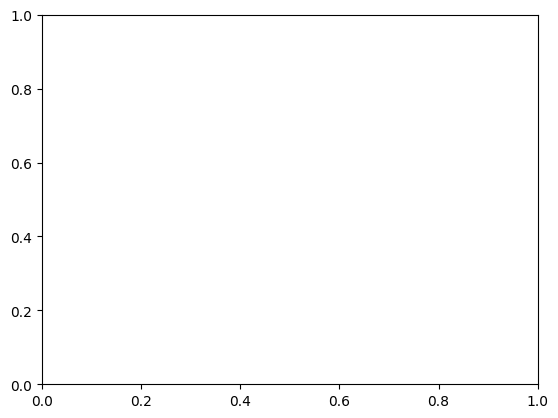

In [127]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (redshift_range, color, marker, label) in enumerate(zip(redshift_ranges, colors, markers, redshift_labels)):
    x = redshift_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    redshift_mask = (filtered_redshifts >= x) & (filtered_redshifts < redshift_range[1])
    filtered_satellites_redshift = filtered_satellites_sfr[redshift_mask]
    filtered_sfr_redshift = filtered_sfr[redshift_mask]

    digitized_mass = np.digitize(filtered_sfr_redshift, bins)

    avg_satellites_redshift = []
    std_satellites_redshift = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_redshift[digitized_mass == i]
        if len(bin_values) > 0:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_redshift.append(mean)
            std_satellites_redshift.append(std_error)
        else:
            avg_satellites_redshift.append(np.nan)
            std_satellites_redshift.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_redshift, yerr=std_satellites_redshift, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('SFR Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. SFR')
ax.legend(title='Redshift Range')
ax.set_ylim(bottom = 0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

In [128]:
hosts_comb

,z_NSA,ra_NSA,dec_NSA,M_r_NSA,M_g_NSA,mass_NSA,SERSIC_N_NSA,SERSIC_BA_NSA,SERSIC_PHI_NSA,ELPETRO_BA_NSA,...,n_sats_in_150kpc,n_bright_sats_in_300kpc,N_unrelated_lowz,n_corr_sats_in_300kpc,pairs,n_sat,g-r,Metalicity,SFR,BPT_CLASS
NSAID,,,,,,,,,,,,,,,,,,,,,
350702,0.025517,217.606577,11.927973,-22.025835,-21.269285,10.984602,5.257183,0.857721,120.447998,0.910484,...,2,3,0.023889,4.785405,0,5,0.756550,-9999.000000,-1.175000,-1
352469,0.029077,224.150682,9.369723,-22.206125,-21.470406,10.968457,6.000000,0.665823,84.467041,0.697892,...,3,8,0.029606,13.155597,0,18,0.735720,-9999.000000,-1.172725,-1
522694,0.023125,176.550767,20.391653,-21.987951,-21.289984,10.962545,6.000000,0.734939,12.358368,0.772986,...,2,5,0.035396,8.067079,2,10,0.697968,-9999.000000,-1.408319,4
123564,0.025188,344.508086,13.134494,-21.964119,-21.223104,10.961491,6.000000,0.679418,45.890747,0.731137,...,2,5,0.023366,8.114398,0,7,0.741014,-9999.000000,-1.338538,5
402395,0.027054,123.936865,58.321011,-21.972540,-21.175783,10.959362,3.853148,0.785757,100.288239,0.841223,...,0,1,0.026347,1.470034,0,2,0.796757,-9999.000000,-0.861570,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223240,0.028972,246.393312,40.787191,-17.915770,-15.755199,7.787176,0.500000,1.000000,117.718842,0.880065,...,0,0,0.029435,-0.178604,0,0,2.160570,-9999.000000,-1.191968,2
325710,0.025637,184.642937,12.855764,-18.330580,-17.478563,5.079427,1.436873,0.306668,147.662933,0.469843,...,0,0,0.024082,-0.213055,0,0,0.852016,-9999.000000,-1.152451,2
223226,0.029857,246.441544,39.609182,-8.395647,-9.839364,3.560767,0.709980,0.205326,156.155151,0.183755,...,0,3,0.030867,4.828380,0,0,-1.443717,-9999.000000,-1.447987,-1


In [129]:
hosts_comb['SSFR'] = hosts_comb['SFR'] - hosts_comb['mass_NSA']

In [130]:
hosts_comb['SSFR']

NSAID
350702   -12.159602
352469   -12.141182
522694   -12.370865
123564   -12.300028
402395   -11.820932
            ...    
223240    -8.979144
325710    -6.231878
223226    -5.008754
208673          inf
17347           inf
Name: SSFR, Length: 10408, dtype: float32

In [131]:
sfr = np.array(list(hosts_comb['SSFR']))
mask = (sfr >= -13) & (sfr <= -8.5)
filtered_satellites_sfr = satellites[mask]
filtered_sfr = sfr[mask]
filtered_masses_sfr = masses[mask]

TypeError: only integer scalar arrays can be converted to a scalar index

In [132]:
bins = np.linspace(-13, -8.5, 6)
digitized = np.digitize(filtered_sfr, bins)
average_satellites = [filtered_satellites_sfr[digitized == i].mean() if len(filtered_satellites_sfr[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

(array([  14.,  210., 1620., 1561., 1123., 1122., 2464., 1926.,  242.,
          17.]),
 array([-13.  , -12.55, -12.1 , -11.65, -11.2 , -10.75, -10.3 ,  -9.85,
         -9.4 ,  -8.95,  -8.5 ]),
 <BarContainer object of 10 artists>)

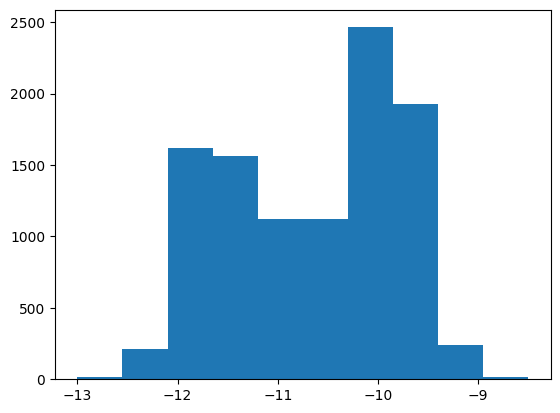

In [133]:
plt.hist(list(hosts_comb['SSFR']), bins = 10, range = (-13, -8.5))

In [ ]:
quartiles = np.percentile(filtered_masses_sfr, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = []
i = 0
for mass_range in mass_ranges:
  x = mass_range[0]
  if(i == 0):
    x = -np.inf
  i += 1
  mass_labels.append(str(round(np.median(filtered_masses_new[(filtered_masses_new >= x) & (filtered_masses_new <  mass_range[1])]), 2)))
colors = ['blue', 'green', 'red', 'orange']

In [ ]:
import numpy as np

# Define mass bins
mass_ranges = [(9.5, 9.75), (9.75, 10), (10, 10.5), (10.5, 11)]

# Create labels for the mass bins
mass_labels = []
for mass_range in mass_ranges:
    x = mass_range[0]
    y = mass_range[1]
    median_mass = np.median(filtered_masses_new[(filtered_masses_new >= x) & (filtered_masses_new < y)])
    mass_labels.append(str(round(median_mass, 2)))

# Define colors for each bin
colors = ['blue', 'green', 'red', 'orange']

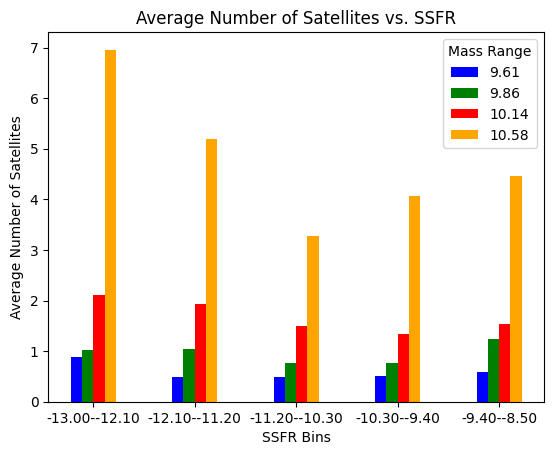

In [ ]:
fig, ax = plt.subplots()

bar_width = 0.10
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_sfr >= x) & (filtered_masses_sfr < mass_range[1])
    filtered_satellites_mass = filtered_satellites_sfr[mass_mask]
    filtered_sfr_mass = filtered_sfr[mass_mask]

    digitized_mass = np.digitize(filtered_sfr_mass, bins)
    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('SSFR Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. SSFR')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)
ax.set_ylim(bottom = 0)

plt.show()

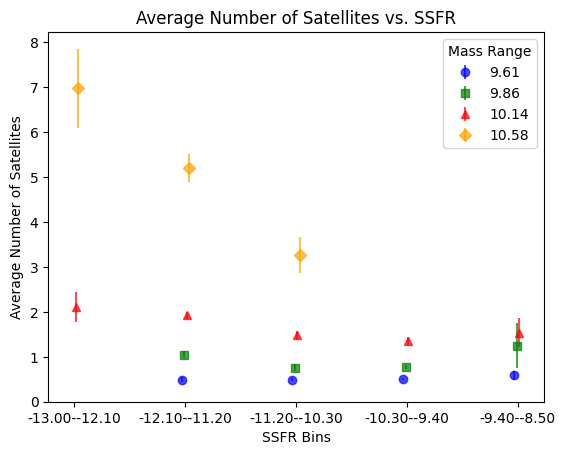

In [ ]:
fig, ax = plt.subplots()

bar_width = 0.04
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_sfr >= x) & (filtered_masses_sfr < mass_range[1])
    filtered_satellites_mass = filtered_satellites_sfr[mass_mask]
    filtered_sfr_mass = filtered_sfr[mass_mask]

    digitized_mass = np.digitize(filtered_sfr_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 30:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('SSFR Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. SSFR')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)
ax.set_ylim(ymin=0)

plt.show()

In [ ]:
hosts.columns

Index(['z_NSA', 'ra_NSA', 'dec_NSA', 'M_r_NSA', 'M_g_NSA', 'mass_NSA',
       'SERSIC_N_NSA', 'SERSIC_BA_NSA', 'SERSIC_PHI_NSA', 'ELPETRO_BA_NSA',
       'PLATE', 'MJD', 'FIBERID', 'mass_GSE', 'mass_err_GSE',
       'n_sats_in_300kpc', 'n_sats_in_150kpc', 'n_bright_sats_in_300kpc',
       'N_unrelated_lowz', 'n_corr_sats_in_300kpc', 'n_sat', 'g-r', 'n_fp',
       'n_non_satellite', 'n_sats_corr'],
      dtype='object')

In [ ]:
hosts

,z_NSA,ra_NSA,dec_NSA,M_r_NSA,M_g_NSA,mass_NSA,SERSIC_N_NSA,SERSIC_BA_NSA,SERSIC_PHI_NSA,ELPETRO_BA_NSA,...,n_sats_in_300kpc,n_sats_in_150kpc,n_bright_sats_in_300kpc,N_unrelated_lowz,n_corr_sats_in_300kpc,n_sat,g-r,n_fp,n_non_satellite,n_sats_corr
NSAID,,,,,,,,,,,,,,,,,,,,,
350702,0.025517,217.606577,11.927973,-22.025835,-21.269285,10.984602,5.257183,0.857721,120.447998,0.910484,...,3,2,3,0.023889,4.785405,5,0.756550,0.375269,0.024684631616734908,7.933379805390768
352469,0.029077,224.150682,9.369723,-22.206125,-21.470406,10.968457,6.000000,0.665823,84.467041,0.697892,...,8,3,8,0.029606,13.155597,18,0.735720,0.276213,0.030589832824063273,29.693196899125347
522694,0.023125,176.550767,20.391653,-21.987951,-21.289984,10.962545,6.000000,0.734939,12.358368,0.772986,...,5,2,5,0.035396,8.067079,10,0.697968,0.426193,0.03656811103279412,16.203905215968852
123564,0.025188,344.508086,13.134494,-21.964119,-21.223104,10.961491,6.000000,0.679418,45.890747,0.731137,...,5,2,5,0.023366,8.114398,7,0.741014,0.359053,0.02414410955328825,11.283469135739534
402395,0.027054,123.936865,58.321011,-21.972540,-21.175783,10.959362,3.853148,0.785757,100.288239,0.841223,...,1,0,1,0.026347,1.470034,2,0.796757,0.310010,0.02722279902625509,2.996100408424566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223240,0.028972,246.393312,40.787191,-17.915770,-15.755199,7.787176,0.500000,1.000000,117.718842,0.880065,...,0,0,0,0.029435,-0.178604,0,2.160570,0.014959,0.030414327478539324,-0.04537302814951288
325710,0.025637,184.642937,12.855764,-18.330580,-17.478563,5.079427,1.436873,0.306668,147.662933,0.469843,...,0,0,0,0.024082,-0.213055,0,0.852016,0.019038,0.02488331942717315,-0.043921314989053606
223226,0.029857,246.441544,39.609182,-8.395647,-9.839364,3.560767,0.709980,0.205326,156.155151,0.183755,...,3,0,3,0.030867,4.828380,0,-1.443717,0.014098,0.03189409112852005,-0.04599173630821066


In [ ]:
# Create a DataFrame
data = {
    'redshift': hosts['z_NSA'],
    'N_sat': hosts['n_sat'],
    'N_corrected_sat': hosts['n_sats_corr'],
    'N_false_positive': hosts['n_fp'],
    'N_non_satellite': hosts['n_non_satellite'],
    'stellar_mass': hosts['mass_NSA'],
    'sSFR': hosts_comb['SSFR'],
    'metallicity': hosts_comb['Metalicity']
}



df = pd.DataFrame(data)

df = df[
    (df['N_sat'] >= -50) &
    (df['N_corrected_sat'] >= -50) &
    (df['N_false_positive'] >= -50) &
    (df['N_non_satellite'] >= -50) &
    (df['stellar_mass'] >= -50) &
    (df['sSFR'] >= -50) &
    (df['metallicity'] >= -50)
]

# Define quartile bins for redshifts
redshift_quartiles = np.percentile(df['redshift'], [0, 25, 50, 75, 100])
df['redshift_bin'] = pd.cut(df['redshift'], bins=redshift_quartiles, include_lowest=True)

quartile_labels = df.groupby('redshift_bin')['redshift'].median().values
df['redshift_bin'] = pd.cut(df['redshift'], bins=redshift_quartiles, labels=quartile_labels)

# Group by the new quartile bins and calculate the mean for each group
grouped_df = df.groupby('redshift_bin').mean()

<ipython-input-97-95aa9a26cb30>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['redshift_bin'] = pd.cut(df['redshift'], bins=redshift_quartiles, include_lowest=True)
<ipython-input-97-95aa9a26cb30>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['redshift_bin'] = pd.cut(df['redshift'], bins=redshift_quartiles, labels=quartile_labels)


In [ ]:
grouped_df

,redshift,N_sat,N_corrected_sat,N_false_positive,N_non_satellite,stellar_mass,sSFR,metallicity
redshift_bin,,,,,,,,
0.02189035341143608,0.021821,0.664466,0.982348444737564,0.077239,0.047856989655078716,9.677276,-9.930577,8.983436
0.024553801864385605,0.024581,0.518112,0.7752163092686593,0.060416,0.027887453183001728,9.664392,-9.855976,8.971328
0.027112504467368126,0.027096,0.396268,0.5835160251011811,0.049636,0.02729409231452292,9.662612,-9.833170,8.968859
0.029124725610017776,0.029107,0.343578,0.4985592283824356,0.043431,0.03064074492722115,9.669888,-9.798292,8.964128


In [79]:
def completeness_model(z, a, b):
    return a / z + b

In [80]:
data = {
    'redshift': [0.021821, 0.024581, 0.027096, 0.029107],
    'N_corrected_sat': [0.982348444737564, 0.7752163092686593, 0.5835160251011811, 0.4985592283824356]
}

In [81]:
data = pd.DataFrame(data)

In [82]:
z = data['redshift']
N_corrected = data['N_corrected_sat']

In [83]:
from scipy.optimize import curve_fit
params, covariance = curve_fit(completeness_model, z, N_corrected)

In [84]:
params

array([ 0.04310515, -0.99027628])

In [85]:
a, b = params
data['completeness'] = completeness_model(z, a, b)

In [86]:
sum = 0
for i in range(0, len(hosts)):
  sum += completeness_model(hosts.iloc[i]['z_NSA'], a, b)
average = sum/len(hosts)

In [87]:
average

0.7099569865220069

In [88]:
data

,redshift,N_corrected_sat,completeness
0,0.021821,0.982348,0.985121
1,0.024581,0.775216,0.763320
2,0.027096,0.583516,0.600555
3,0.029107,0.498559,0.490644


In [89]:
data['completeness'].mean()

0.709910001872469

In [90]:
def adjust_completeness_intercept(z, a, target_avg):
    initial_avg = average
    adjustment = target_avg - initial_avg
    new_b = b + adjustment
    return new_b

In [91]:
b = adjust_completeness_intercept(z, a, 0.6)

In [92]:
b

-1.100233264077512

In [93]:
data['adjusted_completeness'] = completeness_model(z, a, b)

In [94]:
print(a, b)

0.04310515091442428 -1.100233264077512


In [95]:
data.drop('completeness', axis = 1)

,redshift,N_corrected_sat,adjusted_completeness
0,0.021821,0.982348,0.875164
1,0.024581,0.775216,0.653363
2,0.027096,0.583516,0.490598
3,0.029107,0.498559,0.380687


In [96]:
def completeness(z):
  return completeness_model(z, a, b)

Paired vs Isolated

In [134]:
filtered_none = hosts[hosts['pairs'] == 0]
filtered_pair = hosts[hosts['pairs'] == 2]
filtered_multiple = hosts[hosts['pairs'] == 3]

In [135]:
bin1 = []
bin2 = []
bin3 = []
bin4 = []

In [136]:
for i in range(0, len(filtered_none)):
  val = filtered_none.iloc[i]
  if(val['mass_NSA'] > 9.5 and val['mass_NSA'] <= 9.75):
    bin1.append(val['n_sat'])
  elif(val['mass_NSA'] < 10 and val['mass_NSA'] >= 9.75):
    bin2.append(val['n_sat'])
  elif(val['mass_NSA'] < 10.5 and val['mass_NSA'] >= 10):
    bin3.append(val['n_sat'])
  elif(val['mass_NSA'] > 10.5):
    bin4.append(val['n_sat'])

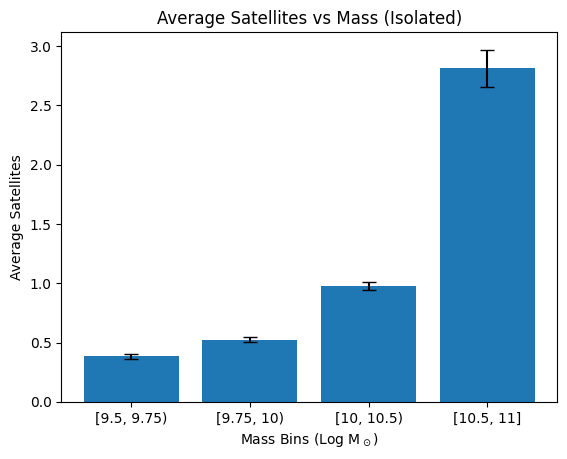

In [137]:
# Calculate average and standard error for each bin
bin_values = [bin1, bin2, bin3, bin4]
avg_values = []
std_errors = []

for bin_val in bin_values:
    if len(bin_val) > 0:
        mean, std_error = calculate_bootstrap_statistics(bin_val)
        avg_values.append(mean)
        std_errors.append(std_error)
    else:
        avg_values.append(np.nan)
        std_errors.append(np.nan)

# Plotting
groups = ['[9.5, 9.75)', '[9.75, 10)', '[10, 10.5)', '[10.5, 11]']
fig, ax = plt.subplots()

ax.bar(groups, avg_values, yerr=std_errors, capsize=5)
ax.set_xlabel('Mass Bins (Log M$_\odot$)')
ax.set_ylabel('Average Satellites')
ax.set_title('Average Satellites vs Mass (Isolated)')

plt.show()

In [138]:
bin1 = []
bin2 = []
bin3 = []
bin4 = []

In [139]:
for i in range(0, len(filtered_pair)):
  val = filtered_pair.iloc[i]
  if(val['mass_NSA'] > 9.5 and val['mass_NSA'] <= 9.75):
    bin1.append(val['n_sat'])
  elif(val['mass_NSA'] < 10 and val['mass_NSA'] >= 9.75):
    bin2.append(val['n_sat'])
  elif(val['mass_NSA'] < 10.5 and val['mass_NSA'] >= 10):
    bin3.append(val['n_sat'])
  elif(val['mass_NSA'] > 10.5):
    bin4.append(val['n_sat'])

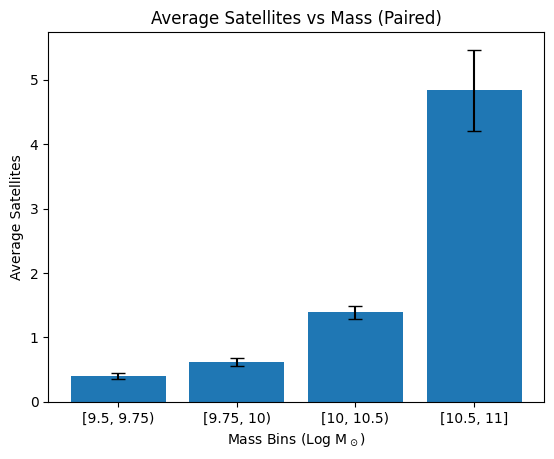

In [140]:
# Calculate average and standard error for each bin
bin_values = [bin1, bin2, bin3, bin4]
avg_values = []
std_errors = []

for bin_val in bin_values:
    if len(bin_val) > 0:
        mean, std_error = calculate_bootstrap_statistics(bin_val)
        avg_values.append(mean)
        std_errors.append(std_error)
    else:
        avg_values.append(np.nan)
        std_errors.append(np.nan)

# Plotting
groups = ['[9.5, 9.75)', '[9.75, 10)', '[10, 10.5)', '[10.5, 11]']
fig, ax = plt.subplots()

ax.bar(groups, avg_values, yerr=std_errors, capsize=5)
ax.set_xlabel('Mass Bins (Log M$_\odot$)')
ax.set_ylabel('Average Satellites')
ax.set_title('Average Satellites vs Mass (Paired)')

plt.show()

In [141]:
bin1 = []
bin2 = []
bin3 = []
bin4 = []

In [142]:
for i in range(0, len(filtered_multiple)):
  val = filtered_multiple.iloc[i]
  if(val['mass_NSA'] > 9.5 and val['mass_NSA'] <= 9.75):
    bin1.append(val['n_sat'])
  elif(val['mass_NSA'] < 10 and val['mass_NSA'] >= 9.75):
    bin2.append(val['n_sat'])
  elif(val['mass_NSA'] < 10.5 and val['mass_NSA'] >= 10):
    bin3.append(val['n_sat'])
  elif(val['mass_NSA'] > 10.5):
    bin4.append(val['n_sat'])

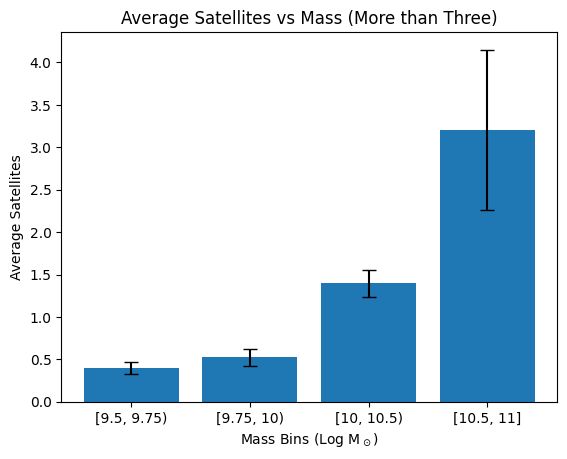

In [143]:
# Calculate average and standard error for each bin
bin_values = [bin1, bin2, bin3, bin4]
avg_values = []
std_errors = []

for bin_val in bin_values:
    if len(bin_val) > 0:
        mean, std_error = calculate_bootstrap_statistics(bin_val)
        avg_values.append(mean)
        std_errors.append(std_error)
    else:
        avg_values.append(np.nan)
        std_errors.append(np.nan)

# Plotting
groups = ['[9.5, 9.75)', '[9.75, 10)', '[10, 10.5)', '[10.5, 11]']
fig, ax = plt.subplots()

ax.bar(groups, avg_values, yerr=std_errors, capsize=5)
ax.set_xlabel('Mass Bins (Log M$_\odot$)')
ax.set_ylabel('Average Satellites')
ax.set_title('Average Satellites vs Mass (More than Three)')

plt.show()

In [144]:
g_r_colors = np.array(list(filtered_none['g-r']))
satellites = np.array(list(filtered_none['n_sats_corr']))
masses = np.array(list(filtered_none['mass_NSA']))
redshifts = np.array(list(filtered_none['z_NSA']))
indices = np.array([i for i in range(0, len(filtered_none))])
mask = (g_r_colors >= 0) & (g_r_colors <= 1)
filtered_satellites = satellites[mask]
filtered_g_r_colors = g_r_colors[mask]
filtered_masses = masses[mask]
filtered_indices = indices[mask]
filtered_redshifts = redshifts[mask]

In [145]:
bins = np.linspace(0, 1, 6)
digitized = np.digitize(filtered_g_r_colors, bins)
average_satellites = [filtered_satellites[digitized == i].mean() if len(filtered_satellites[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [146]:
quartiles = np.percentile(filtered_masses, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = [str(round(np.median(filtered_masses[(filtered_masses >= mass_range[0]) & (filtered_masses < mass_range[1])]), 2)) for mass_range in mass_ranges]
colors = ['blue', 'green', 'red', 'orange']

In [147]:
import numpy as np

# Define mass bins
mass_ranges = [(9.5, 9.75), (9.75, 10), (10, 10.5), (10.5, 11)]

# Create labels for the mass bins
mass_labels = []
for mass_range in mass_ranges:
    x = mass_range[0]
    y = mass_range[1]
    median_mass = np.median(filtered_masses_new[(filtered_masses_new >= x) & (filtered_masses_new < y)])
    mass_labels.append(str(round(median_mass, 2)))

# Define colors for each bin
colors = ['blue', 'green', 'red', 'orange']

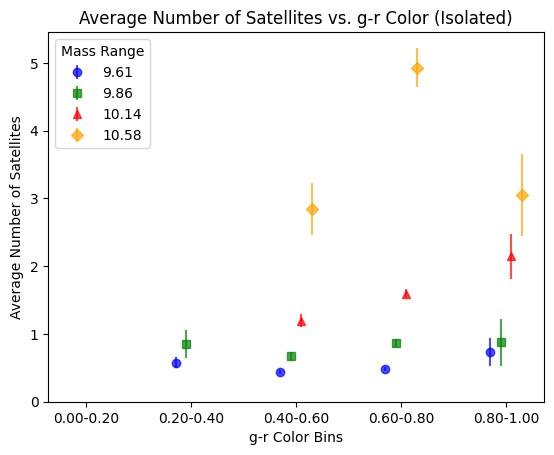

In [148]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses >= x) & (filtered_masses < mass_range[1])
    filtered_satellites_mass = filtered_satellites[mass_mask]
    filtered_g_r_colors_mass = filtered_g_r_colors[mass_mask]

    digitized_mass = np.digitize(filtered_g_r_colors_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 30:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('g-r Color Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. g-r Color (Isolated)')
ax.legend(title='Mass Range')
ax.set_ylim(bottom = 0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

In [149]:
g_r_colors = np.array(list(filtered_pair['g-r']))
satellites = np.array(list(filtered_pair['n_sats_corr']))
masses = np.array(list(filtered_pair['mass_NSA']))
redshifts = np.array(list(filtered_pair['z_NSA']))
indices = np.array([i for i in range(0, len(filtered_pair))])
mask = (g_r_colors >= 0) & (g_r_colors <= 1)
filtered_satellites = satellites[mask]
filtered_g_r_colors = g_r_colors[mask]
filtered_masses = masses[mask]
filtered_indices = indices[mask]
filtered_redshifts = redshifts[mask]

In [150]:
bins = np.linspace(0, 1, 6)
digitized = np.digitize(filtered_g_r_colors, bins)
average_satellites = [filtered_satellites[digitized == i].mean() if len(filtered_satellites[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [151]:
import numpy as np

# Define mass bins
mass_ranges = [(9.5, 9.75), (9.75, 10), (10, 10.5), (10.5, 11)]

# Create labels for the mass bins
mass_labels = []
for mass_range in mass_ranges:
    x = mass_range[0]
    y = mass_range[1]
    median_mass = np.median(filtered_masses_new[(filtered_masses_new >= x) & (filtered_masses_new < y)])
    mass_labels.append(str(round(median_mass, 2)))

# Define colors for each bin
colors = ['blue', 'green', 'red', 'orange']

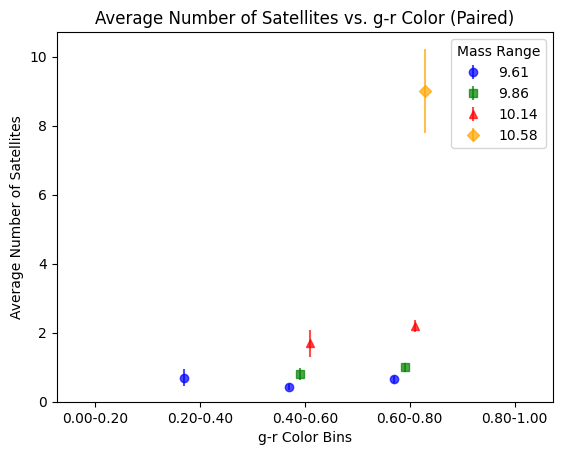

In [152]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses >= x) & (filtered_masses < mass_range[1])
    filtered_satellites_mass = filtered_satellites[mass_mask]
    filtered_g_r_colors_mass = filtered_g_r_colors[mass_mask]

    digitized_mass = np.digitize(filtered_g_r_colors_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 30:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('g-r Color Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. g-r Color (Paired)')
ax.legend(title='Mass Range')
ax.set_ylim(bottom = 0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

In [153]:
g_r_colors = np.array(list(filtered_multiple['g-r']))
satellites = np.array(list(filtered_multiple['n_sats_corr']))
masses = np.array(list(filtered_multiple['mass_NSA']))
redshifts = np.array(list(filtered_multiple['z_NSA']))
indices = np.array([i for i in range(0, len(filtered_multiple))])
mask = (g_r_colors >= 0) & (g_r_colors <= 1)
filtered_satellites = satellites[mask]
filtered_g_r_colors = g_r_colors[mask]
filtered_masses = masses[mask]
filtered_indices = indices[mask]
filtered_redshifts = redshifts[mask]

In [154]:
bins = np.linspace(0, 1, 6)
digitized = np.digitize(filtered_g_r_colors, bins)
average_satellites = [filtered_satellites[digitized == i].mean() if len(filtered_satellites[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [155]:
import numpy as np

# Define mass bins
mass_ranges = [(9.5, 9.75), (9.75, 10), (10, 10.5), (10.5, 11)]

# Create labels for the mass bins
mass_labels = []
for mass_range in mass_ranges:
    x = mass_range[0]
    y = mass_range[1]
    median_mass = np.median(filtered_masses_new[(filtered_masses_new >= x) & (filtered_masses_new < y)])
    mass_labels.append(str(round(median_mass, 2)))

# Define colors for each bin
colors = ['blue', 'green', 'red', 'orange']

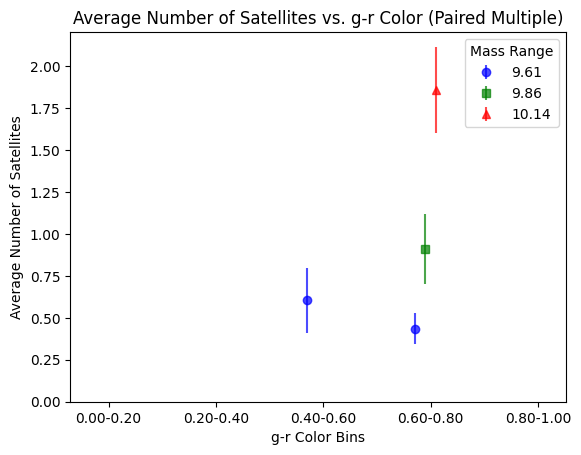

In [156]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
markers = ['o', 's', '^', 'D']
for idx, (mass_range, color, marker, label) in enumerate(zip(mass_ranges, colors, markers, mass_labels)):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses >= x) & (filtered_masses < mass_range[1])
    filtered_satellites_mass = filtered_satellites[mass_mask]
    filtered_g_r_colors_mass = filtered_g_r_colors[mass_mask]

    digitized_mass = np.digitize(filtered_g_r_colors_mass, bins)

    avg_satellites_mass = []
    std_satellites_mass = []
    for i in range(1, len(bins)):
        bin_values = filtered_satellites_mass[digitized_mass == i]
        if len(bin_values) > 30:
            mean, std_error = calculate_bootstrap_statistics(bin_values)
            avg_satellites_mass.append(mean)
            std_satellites_mass.append(std_error)
        else:
            avg_satellites_mass.append(np.nan)
            std_satellites_mass.append(np.nan)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers_offset = bin_centers + (idx - 1.5) * 0.02

    if(not np.all(np.isnan(avg_satellites_mass))):
      ax.errorbar(bin_centers_offset, avg_satellites_mass, yerr=std_satellites_mass, fmt=marker, color=color, label=label, markersize=6, alpha=0.7)

ax.set_xlabel('g-r Color Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. g-r Color (Paired Multiple)')
ax.legend(title='Mass Range')
ax.set_ylim(bottom = 0)

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

(array([  0.,   0.,   0.,   8.,  20.,  42., 164., 250.,  11.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

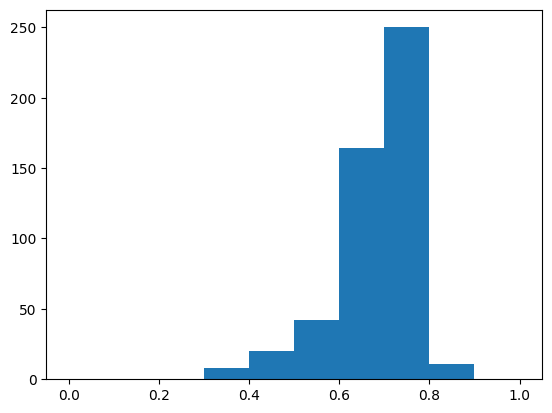

In [157]:
plt.hist(list(filtered_multiple['g-r']), bins = 10, range = (0, 1))

(array([  0.,   0.,   3.,  37., 103., 185., 313., 430.,  45.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

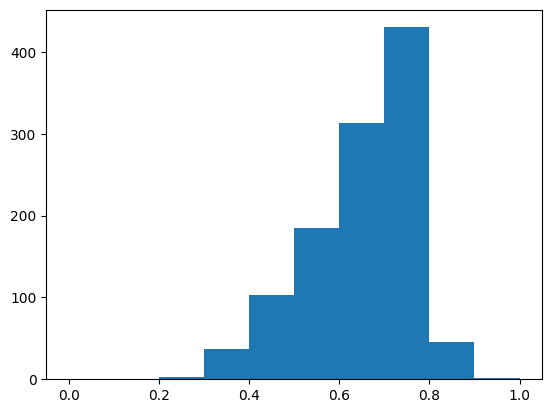

In [158]:
plt.hist(list(filtered_pair['g-r']), bins = 10, range = (0, 1))

(array([1.000e+00, 3.000e+00, 2.700e+01, 3.270e+02, 1.180e+03, 1.416e+03,
        2.023e+03, 2.168e+03, 1.680e+02, 8.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

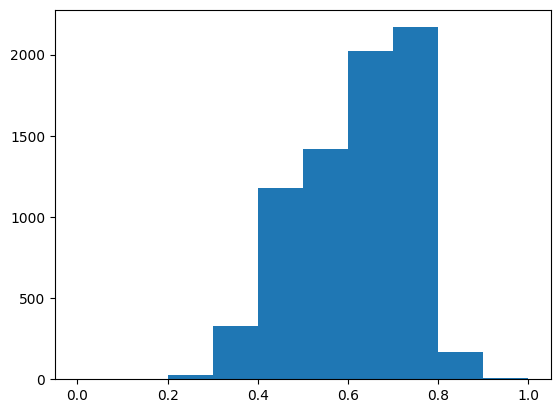

In [159]:
plt.hist(list(filtered_none['g-r']), bins = 10, range = (0, 1))

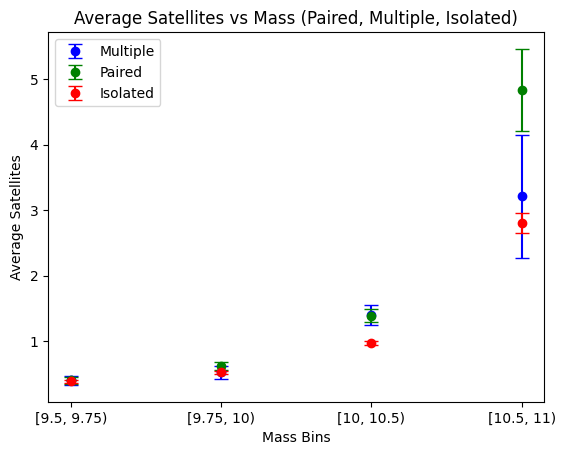

In [162]:
# Define bins for each category
def define_bins(filtered_data):
    bin1, bin2, bin3, bin4 = [], [], [], []
    for i in range(0, len(filtered_data)):
        val = filtered_data.iloc[i]
        if val['mass_NSA'] > 9.5 and val['mass_NSA'] <= 9.75:
            bin1.append(val['n_sat'])
        elif val['mass_NSA'] < 10 and val['mass_NSA'] >= 9.75:
            bin2.append(val['n_sat'])
        elif val['mass_NSA'] < 10.5 and val['mass_NSA'] >= 10:
            bin3.append(val['n_sat'])
        elif val['mass_NSA'] > 10.5:
            bin4.append(val['n_sat'])
    return [bin1, bin2, bin3, bin4]

# Calculate average and standard error for each bin
def calculate_avg_std(bin_values):
    avg_values, std_errors = [], []
    for bin_val in bin_values:
        if len(bin_val) > 0:
            mean, std_error = calculate_bootstrap_statistics(bin_val)
            avg_values.append(mean)
            std_errors.append(std_error)
        else:
            avg_values.append(np.nan)
            std_errors.append(np.nan)
    return avg_values, std_errors

# Get bins for each category
bin_values_multiple = define_bins(filtered_multiple)
bin_values_pair = define_bins(filtered_pair)
bin_values_none = define_bins(filtered_none)

# Calculate average and standard error for each category
avg_values_multiple, std_errors_multiple = calculate_avg_std(bin_values_multiple)
avg_values_pair, std_errors_pair = calculate_avg_std(bin_values_pair)
avg_values_none, std_errors_none = calculate_avg_std(bin_values_none)

# Plotting
groups = ['[9.5, 9.75)', '[9.75, 10)', '[10, 10.5)', '[10.5, 11)']
x = np.arange(len(groups))

fig, ax = plt.subplots()

ax.errorbar(x, avg_values_multiple, yerr=std_errors_multiple, fmt='o', label='Multiple', capsize=5, color='blue')
ax.errorbar(x, avg_values_pair, yerr=std_errors_pair, fmt='o', label='Paired', capsize=5, color='green')
ax.errorbar(x, avg_values_none, yerr=std_errors_none, fmt='o', label='Isolated', capsize=5, color='red')

ax.set_xlabel('Mass Bins')
ax.set_ylabel('Average Satellites')
ax.set_title('Average Satellites vs Mass (Paired, Multiple, Isolated)')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()

plt.show()